In [1]:
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
np.random.seed(777)
import math
import keras
import keras.backend as K
import h5py
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD, RMSprop
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input, Activation, merge, Dense, Flatten, Dropout, concatenate
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization, add, GlobalAveragePooling2D
from keras.utils.np_utils import to_categorical
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score,roc_curve, confusion_matrix, roc_auc_score, auc, f1_score
from keras.regularizers import l2
from keras.applications.xception import Xception, preprocess_input
from keras.applications.mobilenet import MobileNet
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from keras.applications import DenseNet201
from keras.applications import DenseNet121

from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, Lambda,Concatenate
from keras.layers import SeparableConv2D, AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, Add

import matplotlib.pyplot as plt
%matplotlib inline

plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

Using TensorFlow backend.


In [6]:
train_dir = 'data/bioimaging/train/'
test_dir = "data/bioimaging/test/"

extracted_features_dir = "extracted_features/"
model_name = "bioimaging_InceptionV3"

In [7]:
import keras
import tensorflow as tf
import keras.backend as K

print("Keras Version", keras.__version__)
print("tensorflow Version", tf.__version__)
print("dim_ordering:", K.image_dim_ordering())

Keras Version 2.2.4
tensorflow Version 1.10.0
dim_ordering: tf


In [8]:
batch_size = 32
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
epochs = 1000

In [9]:
for root,dirs,files in os.walk(train_dir):
    print (root, len(files))

print("*"*30)
for root,dirs,files in os.walk(test_dir):
    print (root, len(files))

data/bioimaging/train/ 0
data/bioimaging/train/carcinoma 5696
data/bioimaging/train/non-carcinoma 5696
******************************
data/bioimaging/test/ 0
data/bioimaging/test/carcinoma 36
data/bioimaging/test/non-carcinoma 35


In [10]:
random_seed = np.random.seed(1142)

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    featurewise_center=True,
    featurewise_std_normalization=True,
    validation_split= 0.25,
    zoom_range=0.2,
    shear_range=0.2)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'training',
    class_mode='categorical')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    subset = 'validation',
    class_mode='categorical')

test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    seed = random_seed,
    shuffle = False,
    class_mode='categorical')

Found 8544 images belonging to 2 classes.
Found 2848 images belonging to 2 classes.
Found 71 images belonging to 2 classes.


In [11]:
nb_train_samples = len(train_generator.filenames)
nb_validation_samples = len(validation_generator.filenames)
predict_size_train = int(math.ceil(nb_train_samples / batch_size))
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))

nb_test_samples = len(test_generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

# nb_test_without_aug_samples = len(test_generator_without_aug.filenames)
# predict_size_test_without_aug = int(math.ceil(nb_test_without_aug_samples / batch_size))

num_classes = len(train_generator.class_indices)

print("nb_train_samples:", nb_train_samples)
print("nb_validation_samples:", nb_validation_samples)
print("\npredict_size_train:", predict_size_train)
print("predict_size_validation:", predict_size_validation)
# print("nb_test_without_aug_samples:", nb_test_without_aug_samples)
# print("predict_size_test_without_aug_samples:", predict_size_test_without_aug)
print("nb_test_samples:", nb_test_samples)
print("predict_size_test:", predict_size_test)

print("\n num_classes:", num_classes)

nb_train_samples: 8544
nb_validation_samples: 2848

predict_size_train: 267
predict_size_validation: 89
nb_test_samples: 71
predict_size_test: 3

 num_classes: 2


In [12]:
# from keras.backend.tensorflow_backend import get_session
# from keras.backend.tensorflow_backend import clear_session
# from keras.backend.tensorflow_backend import set_session

# def reset_keras_tf_session():
#     """
#     this function clears the gpu memory and set the 
#     tf session to not use the whole gpu
#     """
#     sess = get_session()
#     clear_session()
#     sess.close()
#     sess = get_session()

# #     config = tf.ConfigProto()
# #     config.gpu_options.allow_growth = True
# #     set_session(tf.Session(config=config))


# reset_keras_tf_session()

In [13]:
# from keras.applications.mobilenetv2 import MobileNetV2
# from keras.applications.densenet import DenseNet169
# from keras.applications.vgg19 import VGG19
from keras.applications.inception_v3 import InceptionV3
# from keras.applications.vgg16 import VGG16
# from keras.applications.xception import Xception, preprocess_input
# from keras.applications import DenseNet201
# from keras.applications import DenseNet121
# from keras.applications import ResNet50
# from keras.applications.inception_resnet_v2 import InceptionResNetV2
# from keras.applications import NASNetLarge, NASNetMobile
# from keras.applications import MobileNet


input_tensor = Input(shape = input_shape)  
model = InceptionV3(weights='imagenet', include_top=False, pooling = 'avg', input_tensor=input_tensor)
bottleneck_final_model = model

In [ ]:
# for i, layer in enumerate(model.layers):
#     print(i, layer.name)

In [14]:
# c1 = model.layers[9].output 
# c1 = GlobalAveragePooling2D()(c1)       

# c2 = model.layers[55].output
# c2 = GlobalAveragePooling2D()(c2)       

# c3 = model.layers[143].output
# c3 = GlobalAveragePooling2D()(c3)       

# c4 = model.layers[483].output
# c4 = GlobalAveragePooling2D()(c4)

# con = concatenate([c1, c2, c3, c4])

# bottleneck_final_model = Model(inputs=model.input, outputs=con)

In [15]:
# bottleneck_final_model.summary()

In [16]:
bottleneck_features_train = bottleneck_final_model.predict_generator(train_generator, predict_size_train)
np.save(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy', bottleneck_features_train)

In [17]:
bottleneck_features_validation = bottleneck_final_model.predict_generator(validation_generator, predict_size_validation)
np.save(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy', bottleneck_features_validation)

bottleneck_features_test = bottleneck_final_model.predict_generator(test_generator, predict_size_test)
np.save(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy', bottleneck_features_test)

In [18]:
train_data = np.load(extracted_features_dir+'bottleneck_features_train_'+model_name+'.npy')
validation_data = np.load(extracted_features_dir+'bottleneck_features_validation_'+model_name+'.npy')
test_data = np.load(extracted_features_dir+'bottleneck_features_test_'+model_name+'.npy')

train_labels = train_generator.classes
train_labels = to_categorical(train_labels, num_classes=num_classes)

validation_labels = validation_generator.classes
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

test_labels = test_generator.classes
test_labels = to_categorical(test_labels, num_classes=num_classes)

In [19]:
dropout_rate = 0.4

model = Sequential()
# model.add(Flatten(input_shape=train_data.shape[1:]))
model.add(Dense(256, activation='relu'))
model.add(Dropout(dropout_rate))
model.add(Dense(num_classes, activation=tf.nn.softmax))

adam_opt2=Adam(lr = 0.0001, beta_1=0.6, beta_2=0.9, amsgrad=False)

model.compile(optimizer=adam_opt2, loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data, train_labels,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(validation_data, validation_labels),
                    verbose= 2)

with open(extracted_features_dir+'history_'+model_name+'.txt','w') as f:
    f.write(str(history.history))

# model.save_weights(top_model_weights_path)
# model.save(top_model_path)

Train on 8544 samples, validate on 2848 samples
Epoch 1/1000
 - 2s - loss: 0.4559 - acc: 0.7811 - val_loss: 0.2833 - val_acc: 0.8940
Epoch 2/1000
 - 1s - loss: 0.2551 - acc: 0.8975 - val_loss: 0.1933 - val_acc: 0.9379
Epoch 3/1000
 - 1s - loss: 0.1822 - acc: 0.9341 - val_loss: 0.1546 - val_acc: 0.9470
Epoch 4/1000
 - 1s - loss: 0.1349 - acc: 0.9552 - val_loss: 0.1432 - val_acc: 0.9470
Epoch 5/1000
 - 1s - loss: 0.1108 - acc: 0.9637 - val_loss: 0.1136 - val_acc: 0.9617
Epoch 6/1000
 - 1s - loss: 0.0883 - acc: 0.9710 - val_loss: 0.1063 - val_acc: 0.9652
Epoch 7/1000
 - 1s - loss: 0.0730 - acc: 0.9766 - val_loss: 0.0975 - val_acc: 0.9631
Epoch 8/1000
 - 1s - loss: 0.0624 - acc: 0.9808 - val_loss: 0.0888 - val_acc: 0.9691
Epoch 9/1000
 - 1s - loss: 0.0515 - acc: 0.9846 - val_loss: 0.0844 - val_acc: 0.9695
Epoch 10/1000
 - 1s - loss: 0.0427 - acc: 0.9881 - val_loss: 0.0774 - val_acc: 0.9744
Epoch 11/1000
 - 1s - loss: 0.0367 - acc: 0.9904 - val_loss: 0.0893 - val_acc: 0.9666
Epoch 12/1000
 

Epoch 94/1000
 - 1s - loss: 2.1750e-05 - acc: 1.0000 - val_loss: 0.1297 - val_acc: 0.9737
Epoch 95/1000
 - 1s - loss: 4.9770e-05 - acc: 1.0000 - val_loss: 0.0763 - val_acc: 0.9835
Epoch 96/1000
 - 1s - loss: 3.0229e-04 - acc: 0.9999 - val_loss: 0.0698 - val_acc: 0.9842
Epoch 97/1000
 - 1s - loss: 4.5572e-05 - acc: 1.0000 - val_loss: 0.0674 - val_acc: 0.9863
Epoch 98/1000
 - 1s - loss: 9.7432e-05 - acc: 1.0000 - val_loss: 0.0731 - val_acc: 0.9835
Epoch 99/1000
 - 1s - loss: 8.1211e-05 - acc: 1.0000 - val_loss: 0.0774 - val_acc: 0.9831
Epoch 100/1000
 - 1s - loss: 3.8874e-05 - acc: 1.0000 - val_loss: 0.0691 - val_acc: 0.9842
Epoch 101/1000
 - 1s - loss: 1.0236e-04 - acc: 1.0000 - val_loss: 0.0700 - val_acc: 0.9838
Epoch 102/1000
 - 1s - loss: 5.1678e-05 - acc: 1.0000 - val_loss: 0.0742 - val_acc: 0.9856
Epoch 103/1000
 - 1s - loss: 7.2096e-05 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9824
Epoch 104/1000
 - 1s - loss: 2.7401e-04 - acc: 0.9999 - val_loss: 0.0733 - val_acc: 0.9838
Epoch

 - 1s - loss: 1.2917e-06 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9842
Epoch 185/1000
 - 1s - loss: 2.2930e-06 - acc: 1.0000 - val_loss: 0.1015 - val_acc: 0.9842
Epoch 186/1000
 - 1s - loss: 1.0112e-06 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9856
Epoch 187/1000
 - 1s - loss: 9.1276e-07 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9846
Epoch 188/1000
 - 1s - loss: 6.6980e-07 - acc: 1.0000 - val_loss: 0.0811 - val_acc: 0.9856
Epoch 189/1000
 - 1s - loss: 2.7627e-07 - acc: 1.0000 - val_loss: 0.0880 - val_acc: 0.9860
Epoch 190/1000
 - 1s - loss: 1.8210e-07 - acc: 1.0000 - val_loss: 0.0857 - val_acc: 0.9849
Epoch 191/1000
 - 1s - loss: 1.3054e-06 - acc: 1.0000 - val_loss: 0.0871 - val_acc: 0.9856
Epoch 192/1000
 - 1s - loss: 1.1593e-06 - acc: 1.0000 - val_loss: 0.0795 - val_acc: 0.9870
Epoch 193/1000
 - 1s - loss: 8.1697e-07 - acc: 1.0000 - val_loss: 0.0889 - val_acc: 0.9838
Epoch 194/1000
 - 1s - loss: 2.0322e-07 - acc: 1.0000 - val_loss: 0.0847 - val_acc: 0.9860
Epoch 195/1000

Epoch 275/1000
 - 1s - loss: 4.2157e-07 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9856
Epoch 276/1000
 - 1s - loss: 1.8023e-07 - acc: 1.0000 - val_loss: 0.0872 - val_acc: 0.9870
Epoch 277/1000
 - 1s - loss: 8.3655e-05 - acc: 0.9999 - val_loss: 0.0882 - val_acc: 0.9863
Epoch 278/1000
 - 1s - loss: 9.4465e-07 - acc: 1.0000 - val_loss: 0.0868 - val_acc: 0.9860
Epoch 279/1000
 - 1s - loss: 6.6379e-07 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9860
Epoch 280/1000
 - 1s - loss: 2.6862e-07 - acc: 1.0000 - val_loss: 0.0977 - val_acc: 0.9838
Epoch 281/1000
 - 1s - loss: 2.3549e-07 - acc: 1.0000 - val_loss: 0.0856 - val_acc: 0.9867
Epoch 282/1000
 - 1s - loss: 3.1753e-07 - acc: 1.0000 - val_loss: 0.0937 - val_acc: 0.9860
Epoch 283/1000
 - 1s - loss: 2.5054e-07 - acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.9860
Epoch 284/1000
 - 1s - loss: 1.8777e-07 - acc: 1.0000 - val_loss: 0.0862 - val_acc: 0.9867
Epoch 285/1000
 - 1s - loss: 1.2732e-07 - acc: 1.0000 - val_loss: 0.0854 - val_acc: 0.9853

 - 1s - loss: 1.3503e-07 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 0.9856
Epoch 366/1000
 - 1s - loss: 1.3406e-07 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9867
Epoch 367/1000
 - 1s - loss: 1.4672e-07 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9860
Epoch 368/1000
 - 1s - loss: 1.2500e-07 - acc: 1.0000 - val_loss: 0.0910 - val_acc: 0.9856
Epoch 369/1000
 - 1s - loss: 1.2429e-07 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9874
Epoch 370/1000
 - 1s - loss: 1.4672e-07 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9856
Epoch 371/1000
 - 1s - loss: 1.3539e-07 - acc: 1.0000 - val_loss: 0.0918 - val_acc: 0.9860
Epoch 372/1000
 - 1s - loss: 2.1602e-07 - acc: 1.0000 - val_loss: 0.0916 - val_acc: 0.9863
Epoch 373/1000
 - 1s - loss: 2.8468e-07 - acc: 1.0000 - val_loss: 0.0955 - val_acc: 0.9856
Epoch 374/1000
 - 1s - loss: 1.4910e-07 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9860
Epoch 375/1000
 - 1s - loss: 1.3364e-07 - acc: 1.0000 - val_loss: 0.0952 - val_acc: 0.9860
Epoch 376/1000

Epoch 456/1000
 - 1s - loss: 1.7826e-07 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 0.9863
Epoch 457/1000
 - 1s - loss: 2.1613e-07 - acc: 1.0000 - val_loss: 0.0854 - val_acc: 0.9867
Epoch 458/1000
 - 1s - loss: 1.2738e-07 - acc: 1.0000 - val_loss: 0.0864 - val_acc: 0.9860
Epoch 459/1000
 - 1s - loss: 1.2188e-07 - acc: 1.0000 - val_loss: 0.0850 - val_acc: 0.9863
Epoch 460/1000
 - 1s - loss: 1.2658e-07 - acc: 1.0000 - val_loss: 0.0848 - val_acc: 0.9867
Epoch 461/1000
 - 1s - loss: 1.2437e-07 - acc: 1.0000 - val_loss: 0.0860 - val_acc: 0.9863
Epoch 462/1000
 - 1s - loss: 1.2811e-07 - acc: 1.0000 - val_loss: 0.0869 - val_acc: 0.9863
Epoch 463/1000
 - 1s - loss: 1.7288e-07 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9863
Epoch 464/1000
 - 1s - loss: 1.7749e-07 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9860
Epoch 465/1000
 - 1s - loss: 1.3331e-07 - acc: 1.0000 - val_loss: 0.0904 - val_acc: 0.9860
Epoch 466/1000
 - 1s - loss: 1.6122e-07 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 0.9870

 - 1s - loss: 1.2660e-07 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 0.9860
Epoch 547/1000
 - 1s - loss: 1.3787e-07 - acc: 1.0000 - val_loss: 0.0888 - val_acc: 0.9856
Epoch 548/1000
 - 1s - loss: 1.5974e-07 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9860
Epoch 549/1000
 - 1s - loss: 1.2838e-07 - acc: 1.0000 - val_loss: 0.0926 - val_acc: 0.9867
Epoch 550/1000
 - 1s - loss: 1.7181e-07 - acc: 1.0000 - val_loss: 0.0984 - val_acc: 0.9863
Epoch 551/1000
 - 1s - loss: 1.3108e-07 - acc: 1.0000 - val_loss: 0.0911 - val_acc: 0.9877
Epoch 552/1000
 - 1s - loss: 3.8448e-07 - acc: 1.0000 - val_loss: 0.0945 - val_acc: 0.9863
Epoch 553/1000
 - 1s - loss: 1.4744e-07 - acc: 1.0000 - val_loss: 0.1112 - val_acc: 0.9849
Epoch 554/1000
 - 1s - loss: 1.4289e-07 - acc: 1.0000 - val_loss: 0.0946 - val_acc: 0.9867
Epoch 555/1000
 - 1s - loss: 6.0624e-07 - acc: 1.0000 - val_loss: 0.0906 - val_acc: 0.9870
Epoch 556/1000
 - 1s - loss: 1.3011e-07 - acc: 1.0000 - val_loss: 0.0920 - val_acc: 0.9874
Epoch 557/1000

Epoch 637/1000
 - 1s - loss: 1.2136e-07 - acc: 1.0000 - val_loss: 0.0882 - val_acc: 0.9870
Epoch 638/1000
 - 1s - loss: 1.2127e-07 - acc: 1.0000 - val_loss: 0.0883 - val_acc: 0.9874
Epoch 639/1000
 - 1s - loss: 1.2946e-07 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9881
Epoch 640/1000
 - 1s - loss: 1.2059e-07 - acc: 1.0000 - val_loss: 0.0911 - val_acc: 0.9867
Epoch 641/1000
 - 1s - loss: 1.2035e-07 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9863
Epoch 642/1000
 - 1s - loss: 1.2534e-07 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 0.9860
Epoch 643/1000
 - 1s - loss: 2.5460e-07 - acc: 1.0000 - val_loss: 0.0968 - val_acc: 0.9867
Epoch 644/1000
 - 1s - loss: 1.4915e-07 - acc: 1.0000 - val_loss: 0.0932 - val_acc: 0.9874
Epoch 645/1000
 - 1s - loss: 1.6057e-07 - acc: 1.0000 - val_loss: 0.0933 - val_acc: 0.9867
Epoch 646/1000
 - 1s - loss: 1.2704e-07 - acc: 1.0000 - val_loss: 0.0891 - val_acc: 0.9874
Epoch 647/1000
 - 1s - loss: 1.3377e-07 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9874

 - 1s - loss: 1.2513e-07 - acc: 1.0000 - val_loss: 0.0923 - val_acc: 0.9860
Epoch 728/1000
 - 1s - loss: 1.2603e-07 - acc: 1.0000 - val_loss: 0.0930 - val_acc: 0.9853
Epoch 729/1000
 - 1s - loss: 1.2991e-07 - acc: 1.0000 - val_loss: 0.0924 - val_acc: 0.9860
Epoch 730/1000
 - 1s - loss: 4.1842e-06 - acc: 1.0000 - val_loss: 0.0908 - val_acc: 0.9863
Epoch 731/1000
 - 1s - loss: 1.8073e-07 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9863
Epoch 732/1000
 - 1s - loss: 1.2248e-07 - acc: 1.0000 - val_loss: 0.0894 - val_acc: 0.9867
Epoch 733/1000
 - 1s - loss: 1.3985e-07 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9856
Epoch 734/1000
 - 1s - loss: 1.2371e-07 - acc: 1.0000 - val_loss: 0.0915 - val_acc: 0.9853
Epoch 735/1000
 - 1s - loss: 1.2226e-07 - acc: 1.0000 - val_loss: 0.0899 - val_acc: 0.9867
Epoch 736/1000
 - 1s - loss: 1.3216e-07 - acc: 1.0000 - val_loss: 0.0877 - val_acc: 0.9867
Epoch 737/1000
 - 1s - loss: 1.5873e-07 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9870
Epoch 738/1000

Epoch 818/1000
 - 1s - loss: 1.2246e-07 - acc: 1.0000 - val_loss: 0.0922 - val_acc: 0.9863
Epoch 819/1000
 - 1s - loss: 1.2066e-07 - acc: 1.0000 - val_loss: 0.0897 - val_acc: 0.9860
Epoch 820/1000
 - 1s - loss: 1.2168e-07 - acc: 1.0000 - val_loss: 0.0895 - val_acc: 0.9863
Epoch 821/1000
 - 1s - loss: 1.4457e-07 - acc: 1.0000 - val_loss: 0.0875 - val_acc: 0.9870
Epoch 822/1000
 - 1s - loss: 1.2119e-07 - acc: 1.0000 - val_loss: 0.0872 - val_acc: 0.9860
Epoch 823/1000
 - 1s - loss: 1.4973e-07 - acc: 1.0000 - val_loss: 0.0858 - val_acc: 0.9856
Epoch 824/1000
 - 1s - loss: 1.1966e-07 - acc: 1.0000 - val_loss: 0.0863 - val_acc: 0.9856
Epoch 825/1000
 - 1s - loss: 1.2942e-07 - acc: 1.0000 - val_loss: 0.0866 - val_acc: 0.9856
Epoch 826/1000
 - 1s - loss: 1.3131e-07 - acc: 1.0000 - val_loss: 0.0881 - val_acc: 0.9863
Epoch 827/1000
 - 1s - loss: 1.2315e-07 - acc: 1.0000 - val_loss: 0.0872 - val_acc: 0.9860
Epoch 828/1000
 - 1s - loss: 1.2135e-07 - acc: 1.0000 - val_loss: 0.0876 - val_acc: 0.9860

 - 1s - loss: 1.6226e-07 - acc: 1.0000 - val_loss: 0.0884 - val_acc: 0.9849
Epoch 909/1000
 - 1s - loss: 1.2363e-07 - acc: 1.0000 - val_loss: 0.0900 - val_acc: 0.9853
Epoch 910/1000
 - 1s - loss: 1.7259e-07 - acc: 1.0000 - val_loss: 0.0939 - val_acc: 0.9870
Epoch 911/1000
 - 1s - loss: 1.2621e-07 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9860
Epoch 912/1000
 - 1s - loss: 1.2123e-07 - acc: 1.0000 - val_loss: 0.0893 - val_acc: 0.9863
Epoch 913/1000
 - 1s - loss: 1.2056e-07 - acc: 1.0000 - val_loss: 0.0896 - val_acc: 0.9863
Epoch 914/1000
 - 1s - loss: 1.9443e-07 - acc: 1.0000 - val_loss: 0.0907 - val_acc: 0.9867
Epoch 915/1000
 - 1s - loss: 1.2247e-07 - acc: 1.0000 - val_loss: 0.0914 - val_acc: 0.9867
Epoch 916/1000
 - 1s - loss: 1.2826e-07 - acc: 1.0000 - val_loss: 0.0852 - val_acc: 0.9867
Epoch 917/1000
 - 1s - loss: 1.4525e-07 - acc: 1.0000 - val_loss: 0.0912 - val_acc: 0.9867
Epoch 918/1000
 - 1s - loss: 1.2007e-07 - acc: 1.0000 - val_loss: 0.0892 - val_acc: 0.9867
Epoch 919/1000

Epoch 999/1000
 - 1s - loss: 1.2351e-07 - acc: 1.0000 - val_loss: 0.0921 - val_acc: 0.9867
Epoch 1000/1000
 - 1s - loss: 1.2039e-07 - acc: 1.0000 - val_loss: 0.0924 - val_acc: 0.9877


In [20]:
preds = model.predict(test_data)

predictions = [i.argmax() for i in preds]
y_true = [i.argmax() for i in test_labels]
cm = confusion_matrix(y_pred=predictions, y_true=y_true)

print('Accuracy {}'.format(accuracy_score(y_true=y_true, y_pred=predictions)))

Accuracy 0.8591549295774648


Confusion Matrix
[[30  6]
 [ 4 31]]


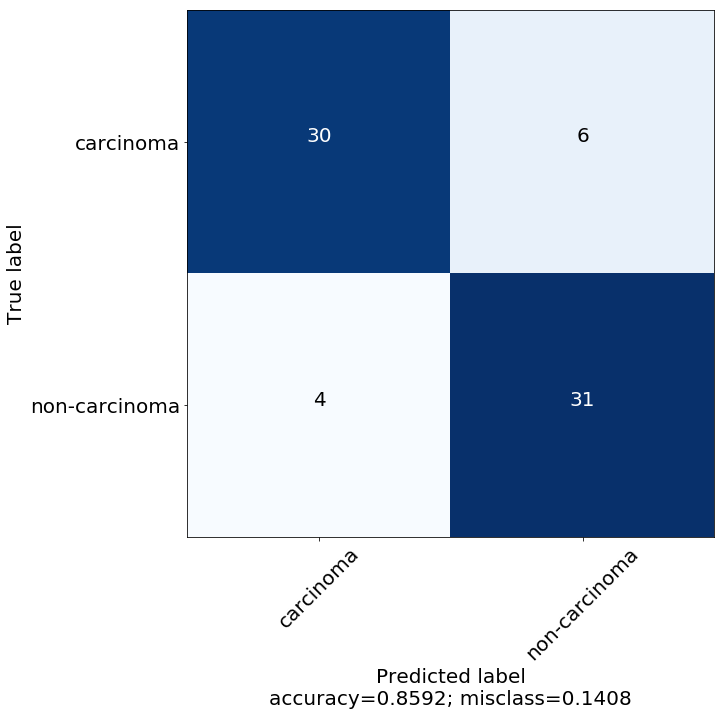

In [21]:
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 20})

labels = []

label = test_generator.class_indices
indexlabel = dict((value, key) for key, value in label.items())

for k,v in indexlabel.items():
    labels.append(v)

from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix')

    print(cm)
#     fig = plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
#     plt.title(title)
#     plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
#     plt.savefig('plots/3.InceptionV3-2-Private-DataSet-CM.png', bbox_inches='tight', dpi = 100) 


plt.figure(figsize=(10,10))
plot_confusion_matrix(cm, classes=labels, title=' ')

In [22]:
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
y_pred=predictions
y_pred_probabilities=y_pred

# y_pred = np.argmax(y_pred,axis = 1) 
y_actual = y_true

classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)

confusion_mtx = confusion_matrix(y_actual, y_pred) 
print(confusion_mtx)
target_names = classnames
print(classification_report(y_actual, y_pred, target_names=target_names))

[[30  6]
 [ 4 31]]
               precision    recall  f1-score   support

    carcinoma       0.88      0.83      0.86        36
non-carcinoma       0.84      0.89      0.86        35

  avg / total       0.86      0.86      0.86        71



In [23]:
total=sum(sum(cm))

sensitivity = cm[0,0]/(cm[0,0]+cm[1,0])
print('Sensitivity : ', sensitivity*100 )

Specificity = cm[1,1]/(cm[1,1]+cm[0,1])
print('Specificity : ', Specificity*100 )

Sensitivity :  88.23529411764706
Specificity :  83.78378378378379


In [24]:
print('roc_auc_score = ' + str(roc_auc_score(predictions, y_true)))

roc_auc_score = 0.8600953895071541


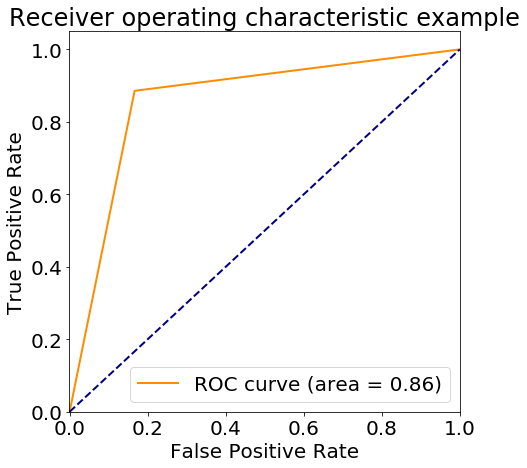

In [25]:
fpr, tpr, thresholds = roc_curve(y_true, predictions)
roc_auc = auc(fpr,tpr)

plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-.001, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

In [26]:
predict = model.predict_proba(test_data, batch_size=batch_size, verbose=1)

71/71 [==============================] - 0s 56us/step


In [27]:
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
y = label_binarize(test_labels, classes=[0, 1])
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y[:, i], predict[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y.ravel(), predict.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [28]:
from scipy import interp
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(num_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= num_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

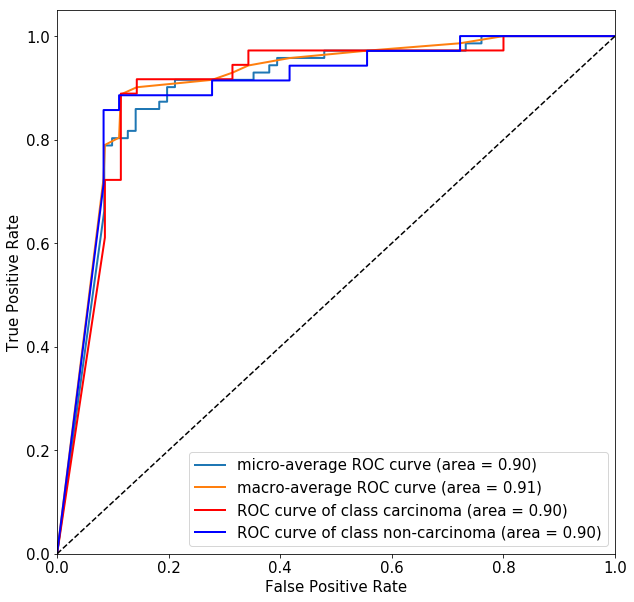

In [29]:
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams["axes.grid"] = False
plt.rcParams.update({'font.size': 15})

from itertools import cycle
classnames=[]
for classname in test_generator.class_indices:
    classnames.append(classname)
    

plt.figure(figsize=(10, 10))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),linewidth=2)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         linewidth=2)
plot_name = 'no variation'
colors = cycle(['red','blue','green','yellow','orange', 'aqua', 'cornflowerblue'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(classnames[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [30]:
tn, fp, fn, tp = cm.ravel()

In [31]:
print("Accuracy:",(tp+tn)/(tp+tn+fp+fn))
print("Precision:",(tp/(tp+fp)))
print("Recall:",(tp/(tp+fn)))
print("tp:", tp) 
print("fp:", fp) 
print("tn:",tn) 
print("fn:",fn)

Accuracy: 0.8591549295774648
Precision: 0.8378378378378378
Recall: 0.8857142857142857
tp: 31
fp: 6
tn: 30
fn: 4


In [32]:
print('F1 score:', f1_score(y_true, y_pred))

F1 score: 0.8611111111111112


In [33]:
recall = (tp/(tp+fn))
precision=(tp/(tp+fp))

f1 = 2 / ( (1/recall) + (1 / precision))
print('F1 score:', f1)

F1 score: 0.861111111111111


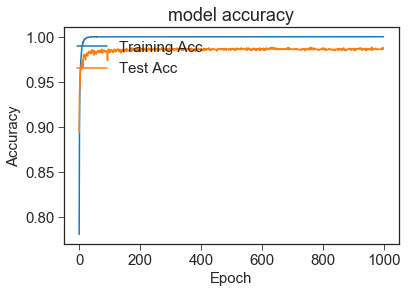

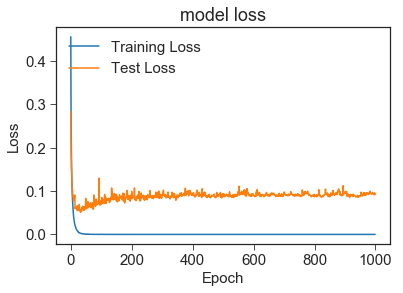

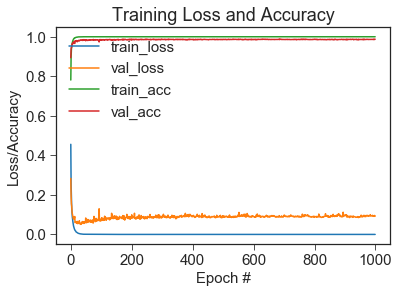

In [34]:
plt.style.use("seaborn-ticks")

plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Acc', 'Test Acc'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Test Loss'], loc='upper left')
plt.show()

plt.figure()
N = epochs
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["acc"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")